In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [3]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from sklearn import decomposition
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state

from population import unit_response_matrix, activity_at_phase, pop_activity_phase_shifted

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
#sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:]
try:
    selected.remove('009266_hippoSIT_2023-04-20_15-24-14')
except:
    pass
try:
    selected.remove('009265_hippoSIT_2023-02-27_10-18-32')
    selected.remove('009265_hippoSIT_2023-02-27_15-33-46')
except:
    pass

# special for 009265
#selected = selected[7:-1]

# showcase
# selected = [
#     '009266_hippoSIT_2023-05-04_19-47-15',
#     '009266_hippoSIT_2023-04-17_17-04-17',
#     '009266_hippoSIT_2023-05-23_09-18-05'
# ]

# potentially also good ones
#'009265_hippoSIT_2023-03-03_09-37-07',
#'009265_hippoSIT_2023-03-04_11-12-04',
#'009265_hippoSIT_2023-03-08_18-10-07',

selected = [
    '009265_hippoSIT_2023-03-09_20-03-08',
    '009265_hippoSIT_2023-03-05_11-52-17',
]

selected = [
    "57_SIT_2023-12-21_15-05-52",
    "57_SIT_2023-12-22_14-08-07",
    "57_SIT_2023-12-22_17-37-18",
    "57_SIT_2023-12-28_16-43-28",
    "57_SIT_2023-12-29_11-06-26",
    "57_SIT_2023-12-29_11-40-14",
    "57_SIT_2024-01-02_16-38-05",
    "57_SIT_2024-01-02_17-10-09",
    "57_SIT_2024-01-03_19-54-59",
]
selected

['57_SIT_2023-12-21_15-05-52',
 '57_SIT_2023-12-22_14-08-07',
 '57_SIT_2023-12-22_17-37-18',
 '57_SIT_2023-12-28_16-43-28',
 '57_SIT_2023-12-29_11-06-26',
 '57_SIT_2023-12-29_11-40-14',
 '57_SIT_2024-01-02_16-38-05',
 '57_SIT_2024-01-02_17-10-09',
 '57_SIT_2024-01-03_19-54-59']

## On neural manifold

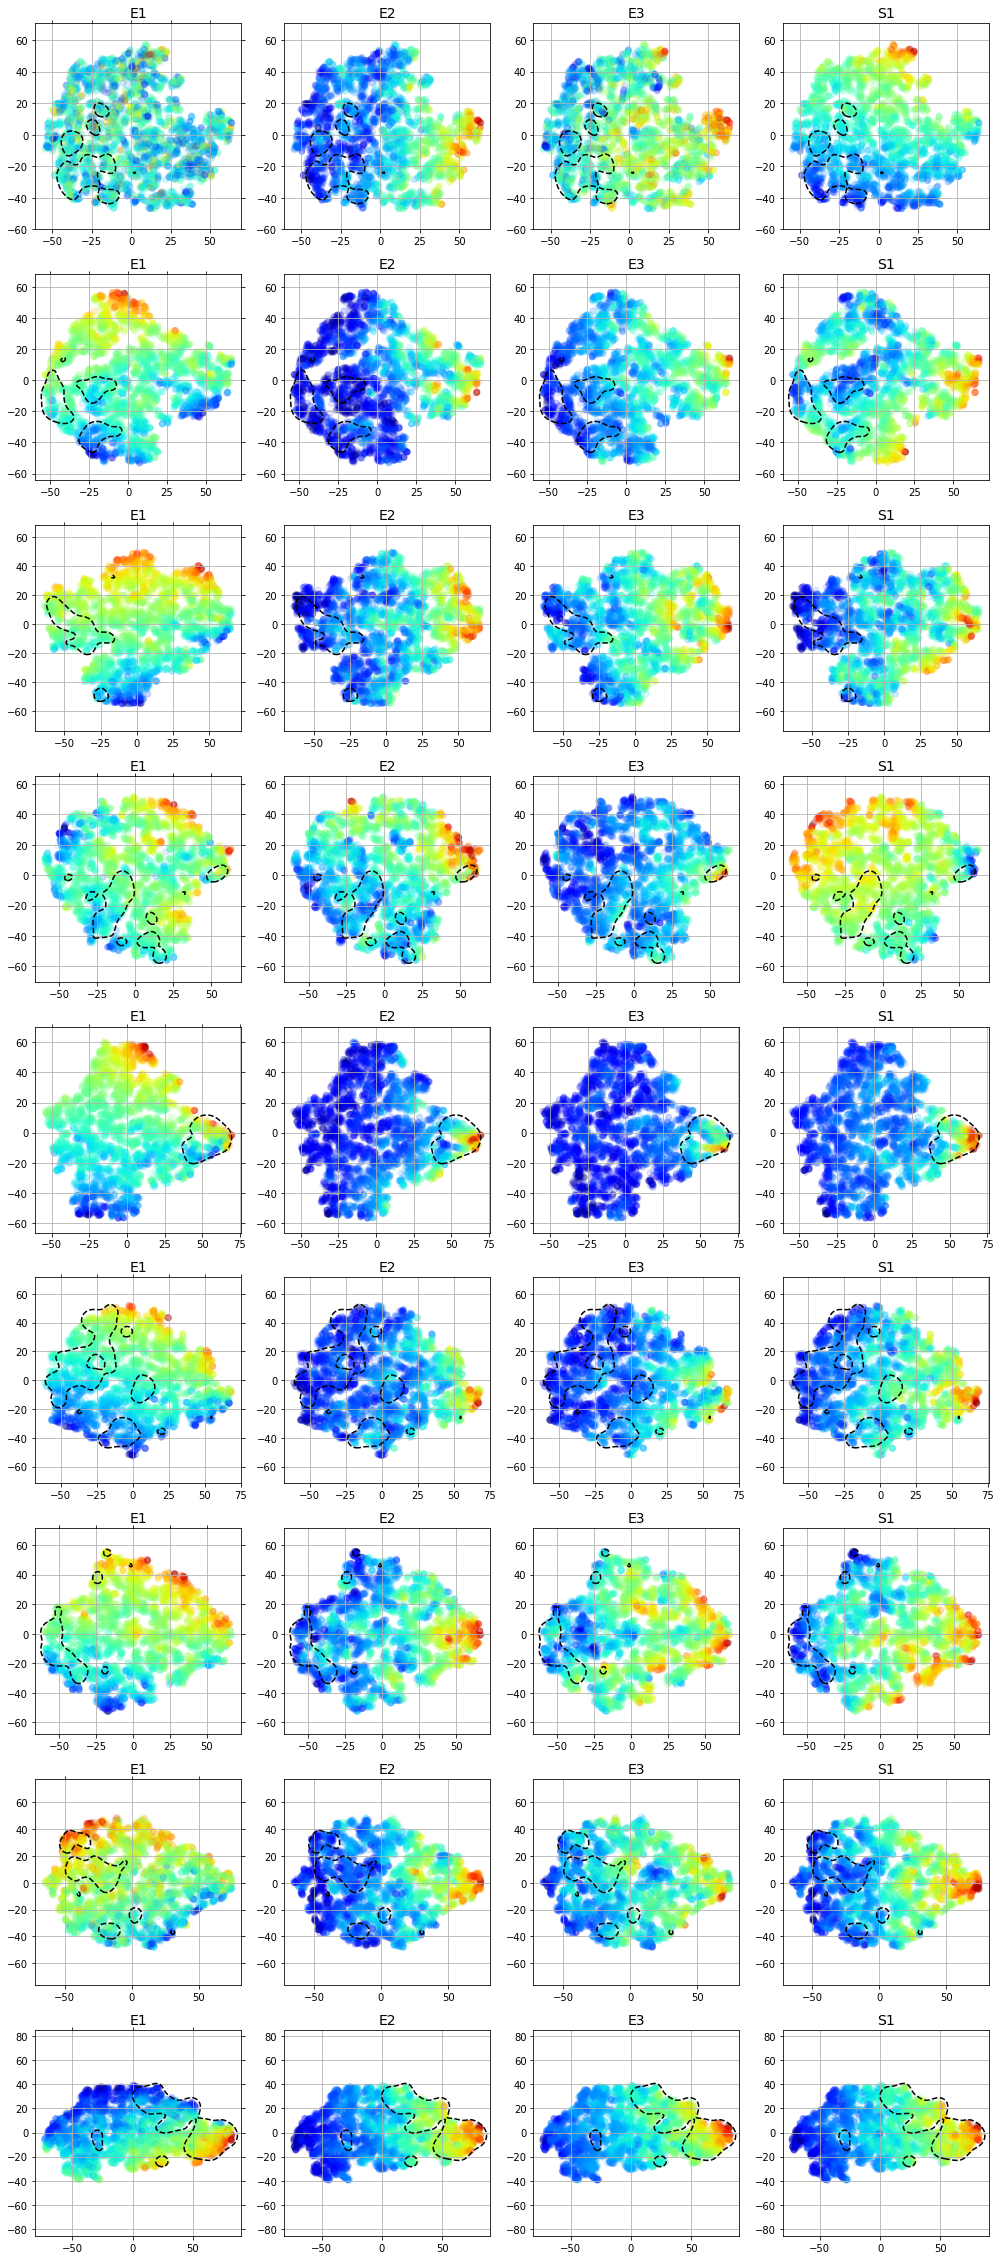

In [9]:
ft, fp = 'tSNE', 70
#ft, fp = 'UMAP', 0.5
sigma = 0.3
titles = ['E1', 'E2', 'E3', 'S1']
rows = len(selected)
cols = len(titles)

fig, axes = plt.subplots(rows, cols, figsize=(14, rows*3.5))

for i, session in enumerate(selected):
    animal = session.split('_')[0]

    s_path     = os.path.join(source, animal, session)
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    umap_file  = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    state_file = os.path.join(source, animal, session, 'analysis', 'state_idxs.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
        cfg = json.loads(f['processed'].attrs['parameters'])
    with h5py.File(umap_file, 'r') as f:
        fit = np.array(f[ft][str(fp)])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
    with h5py.File(state_file, 'r') as f:
        idxs_AL_ev = np.array(f['idxs_AL_ev'])  # bAL state
        idxs_neuro_AL_bgr_ev = np.array(f['idxs_neuro_AL_bgr_ev'])
        idxs_neuro_AL_sil_ev = np.array(f['idxs_neuro_AL_sil_ev'])
        idxs_neuro_PH_bgr_ev = np.array(f['idxs_neuro_PH_bgr_ev'])
        idxs_neuro_PH_sil_ev = np.array(f['idxs_neuro_PH_sil_ev'])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
        b_fit = np.array(f[ft][str(fp)])

    speed_ev = speed[events[:, 2].astype(np.int32)]
    idxs_PH_ev = np.array([x for x in range(len(events)) if not x in idxs_AL_ev])
    
    extent = get_extent(fit, margin=5)
    b_size = extent[1] - extent[0]
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(events[:, 1] == -1)[0]

    idxs_succ_ev = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        idxs_succ_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    idxs_succ_ev = np.array(idxs_succ_ev)
    
    # contours
    d_map  = density_map(fit[idxs_succ_ev], extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.35*d_map.max(), d_map.max(), 2)
    TGT_fit = axes[i][0].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)
    axes[i][0].clear()
    
    #w_mx = np.zeros([len(events), 4])
    #for j in range(4):  # W1-W4 phases
    #    w_mx[:, j] = activity_at_phase(s_path, phase=j+1, do_pca=True, k_width=30)

    times_to_event = [15, 28, 73, 100]
    bins, unit_mx = unit_response_matrix(s_path, [1, 2], times_to_event=times_to_event)

    sig = unit_mx[1::len(times_to_event) + 1].mean(axis=1) * (220/15) # norm by window size
    noi = unit_mx[4::len(times_to_event) + 1].mean(axis=1)

    k_width = 30
    kernel = signal.gaussian(k_width, std=(k_width) / 7.2)
    sig_sm = np.convolve(sig, kernel, 'same') / kernel.sum()
    noi_sm = np.convolve(noi, kernel, 'same') / kernel.sum()

    snr = np.ones(len(sig_sm))
    #idxs_noi_non_zero = np.where(noi_sm != 0)[0]
    #snr[idxs_noi_non_zero] = ((np.abs(sig_sm - noi_sm) + noi_sm)/noi_sm)[idxs_noi_non_zero]
    #snr[idxs_noi_non_zero] = (np.abs(sig_sm - noi_sm)/noi_sm)[idxs_noi_non_zero]
    snr = (np.abs(sig_sm - noi_sm) + noi_sm)/noi_sm

    # just plot W4
    w4 = activity_at_phase(s_path, phase=4, do_pca=True, k_width=30)
    
    # -----------
    binning_mPFC_PCA = {
        50:  [8, 16, 65, 85],
        75:  [8, 16, 90, 110],
        100: [8, 16, 115, 135],
    }
    
    dur_bgr = int(cfg['sound']['sounds']['background']['duration'] * 1000)  # in ms
    dur_tgt = int(cfg['sound']['sounds']['target']['duration'] * 1000)  # in ms

    key_bgr = dur_bgr if dur_bgr in binning_mPFC_PCA else 50
    key_tgt = dur_tgt if dur_tgt in binning_mPFC_PCA else 50
    wx_m = pop_activity_phase_shifted(s_path, binning_mPFC_PCA[key_bgr], binning_mPFC_PCA[key_tgt], do_pca=True)
    
    for k in range(wx_m.shape[1]):
        ax = axes[i][k]
        ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, cmap='jet', c=wx_m[:, k])  # PRGn cmap
        ax.set_title(titles[k], fontsize=14)
        
    # just W1 - W4
#     for k in range(4):
#         wi = activity_at_phase(s_path, phase=k+1, do_pca=True, k_width=30)
#         ax = axes[i][k]
#         ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, cmap='jet', c=wi)  # PRGn cmap
#         ax.set_title(titles[k], fontsize=14)
#     axes[i][0].text(extent[0] + 0.05*b_size, extent[2] + 0.05*b_size, 'Neural manifold', fontsize=14)
    
#     # plotting - bE / bU states
#     ax = axes[i][0]
#     ax.scatter(fit[idxs_PH_ev][:, 0], fit[idxs_PH_ev][:, 1], alpha=0.1, color='navy', label='bU')
#     ax.scatter(fit[idxs_AL_ev][:, 0], fit[idxs_AL_ev][:, 1], alpha=0.1, color='green', label='bE')
#     ax.set_ylabel(session[-19:-6], fontsize=14)
#     ax.set_title("Behavioral state", fontsize=14)
#     ax.legend(loc='lower left')

#     # plotting - speed
#     ax = axes[i][1]
#     ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, cmap='seismic', c=np.log(speed_ev))
#     ax.set_title("Locomotion", fontsize=14)
    
#     # plotting - W4
#     ax = axes[i][2]
#     ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, cmap='seismic', c=w4)
#     ax.set_title("W4", fontsize=14)
    
#     # plotting - SNR
#     ax = axes[i][3]
#     if len(data) < len(fit):
#         data = np.concatenate([data, [data[-1]]])
#     ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, cmap='seismic', c=np.log(snr))
#     ax.set_title("SNR", fontsize=14)
    
    for j, ax in enumerate(axes[i]):
        ax.grid()
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.set_aspect('equal')
        for path in TGT_fit.collections[0].get_paths():
            verts = path.vertices
            ax.plot(verts[:,0], verts[:,1], ls='--', color='black')
            
fig.tight_layout()

In [18]:
fig.savefig(os.path.join(report, 'showroom', 'nMAP_W1_W4_%s_sample_jet.png' % animal), dpi=300)

(array([3147., 2094., 1348., 1212.,  947.,  547.,  190.,   63.,   34.,
          17.]),
 array([4.53660525e-06, 3.67569497e-01, 7.35134458e-01, 1.10269942e+00,
        1.47026438e+00, 1.83782934e+00, 2.20539430e+00, 2.57295926e+00,
        2.94052422e+00, 3.30808918e+00, 3.67565414e+00]),
 <BarContainer object of 10 artists>)

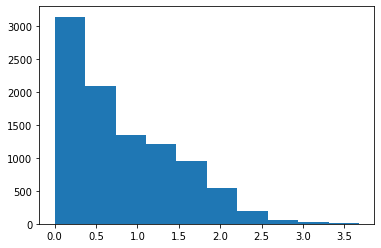

In [45]:
plt.hist(snr)

(array([  13.,   55.,  274.,  945., 1921., 2684., 2217., 1136.,  300.,
          54.]),
 array([-2.97430745, -2.43881141, -1.90331537, -1.36781933, -0.83232329,
        -0.29682724,  0.2386688 ,  0.77416484,  1.30966088,  1.84515692,
         2.38065297]),
 <BarContainer object of 10 artists>)

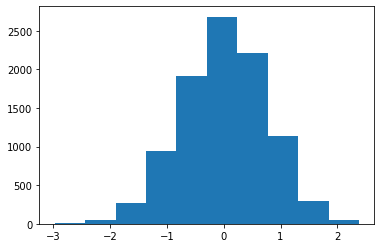

In [41]:
plt.hist(w4)